# آموزش تنسورفلو #01 
# مدل خطی ساده

نوشته شده توسط: [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

توضیحات فارسی: [2860166](https://github.com/2860166/Tensorflow_tutorial_Persian) 

## مقدمه

در این آموزش به نحوه پیاده سازی یک مدل خطی در تنسورفلو میپردازیم. 
ابتدا مجموعه داده شامل تصاویری از اعداد دست نویس انگلیسی بارگزاری شده و سپس یک مدل ریاضی را تعریف و بهینه می‌کنیم. در نهایت نتایج بررسی خواهند شد.

شما باید با مفاهیم جبرخطی، زبان پایتون و همچنین نحوه کار با jupytr notebook آشنا باشید. همچنین آشنایی نسبی با یادگیری ماشین، کمک زیادی به فهم مطلب خواهد کرد.

## بارگذاری و خواندن مجموعه داده

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

این کد بوسیله پایتون نسخه (3.6) و توزیع آناکوندا توسعه یافته است.

In [2]:
tf.__version__

'1.12.0'

## بارگذاری مجموعه داده

MNIST شامل تصاویر اعداد دستنویس انگلیسی است و در مجموع 12 مگابایت حجم دارد. اگر داده ها در مسیر مشخص شده وجود نداشته باشند، به صورت اتوماتیک دانلود خواهند شد.

In [3]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

مجموعه داده شامل 70000 تصویر عدد است. دیتاست شامل سه قسمت داده‌های آموزش، داده ارزیابی و داده تست است. ما فقط از دو مجموعه آموزش و تست استفاده خواهیم کرد.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


برخی ویژگی‌های مجموعه داده

In [5]:
# هر تصویر در یک ارایه یک بعدی با سایز زیر ذخیره می‌شود
img_size_flat = data.img_size_flat

# یک تاپل شامل طول و عرض تصویر برای بدست آوردن آرایه دوبعدی و تصویر واقعی
img_shape = data.img_shape

# تعداد کلاس ها، هر کلاس متناظر با یک عدد
num_classes = data.num_classes

### کدبندی One-Hot 

برچسب یا همان کلاس متناظر هر تصویر به دوصورت موجود است. اول به صورت اعداد متناظر با هر کلاس. در این روش، هر برچسب یک عدد است . روش دوم، کدبندی one-hot است که در آن هر برچسب به صورت یک بردار از اعداد صفرو یک و به طول تعداد کلاسهاست. فقط درایه متناظر با شماره کلاس یک و بقیه درایه ها صفرند.
به عنوان مثال می‌توان کدبندی one-hot مربوط به پنج تصویر اول را مشاهده کرد:

In [6]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

همچنین نوع اول برچسب ها هم موجود و آماده است و در آرایه y_test_cls ذخیره شده اند. مثلا لیبل متناظر با پنج تصویر اول در این روش به صورت زیر هستند:

In [7]:
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

### تابع نمایش تصاویر

تابع زیر برای نمایش 9 تصویر به صورت 3x3 است. همچنین برچسب اصلی و برچسب پیش بینی شده را زیر هر تصویر چاپ می‌کند.

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # ایجاد یک figure 3x3
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # نمایش تصویر
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # نمایش برچسب های اصلی و پیش بینی شده
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # حدف تیک ها از روی محورها
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

### نمایش چند تصویر نمونه بوسیله تابع فوق

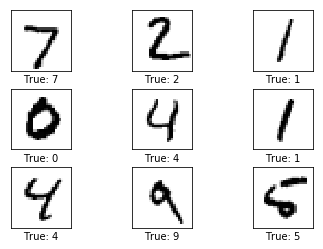

In [9]:
# گرفتن اولین نه تصویر از دیتاست
images = data.x_test[0:9]

# گرفتن برچسب‌های اصلی آن تصاویر
cls_true = data.y_test_cls[0:9]

# نمایش تصاویر با تابع فوق
plot_images(images=images, cls_true=cls_true)

## گراف تنسورفلو

هدف تنسورفلو، ایجاد یک گراف محاسباتی است که به صورت کاراتر از پایتون معمولی اجرا شود. تنسورفلو از numpy سریعتر است زیرا دید کلی دارد و گراف محاسبات کلی را درنظر می‌گیرد؛ در حالی که numpy تنها یک عملگر محاسباتی در یک زمان را می‌شناسد.

یکی دیگر از قابلیت‌های تنسورفلو، توانایی محاسبه گرادیان‌های مورد نیاز برای بهینه‌سازی متغییرها گراف است که موجب عملکرد بهتر مدل است. از آنجا که گراف ترکیبی از عبارتهای ریاضی ساده است، گرادیان کل گراف با استفاده از قانون مشتق زنجیره‌ای، قابل محاسبه است.

همچنین تنسورفلو می‌تواند از پردازنده‌های چندهسته ای و همچنین پردازنده‌های گرافیکی استفاده کند. اخیرا گوگل نیز تراشه‌ای مخصوص اجرای تنسورفلو معرفی کرده است که TPU نام دارد و سریعتر از GPU عمل می‌کند.

گراف تنسورفلو شامل اجزای زیر است:
* متغیر Placeholder که برای دادن ورودی به گراف استفاده می‌شود.
* متغیر Model که قرار است بهینه‌سازی شود تا مدل بهتر عمل کند. 
* مدلی که الزاما یک رابطه ریاضی بین ورودی‌های موجود در placeholder و متغیرهای Model است.
* یک تابع هزینه که برای بهینه‌سازی تعریف می‌شود.
* یک متد بهینه‌سازی برای به‌روزرسانی متغییرهای مدل.

همچنین گراف تنسورفلو می‌تواند شامل عبارت‌هایی دیگر به‌منطور نمایش گزارشات اجرا توسط TensorBoard باشد که در این آموزش به آن نمیپردازیم.

### متغیر Placeholder

متغیر Placeholder مانند ورودی گراف عمل می‌کند که می‌توانیم در هر اجرا آن‌ها را تغییر دهیم.

در این آموزش باید متغییری تعریف کنیم تا تصویری را به‌عنوان ورودی دریافت کند. این عمل به ما امکان می‌دهد که ورودی‌ها را عوض کرده و تصاویر مختلفی را به گراف بدهیم. همچنین به این ورودی‌ها یک تنسور گفته می‌شود که همان آرایه یا بردار چندبعدی است. data-type از نوع `float32` تعریف شده و اندازه آن `[None, img_size_flat]` قرار داده شده است که در آن `None` به این معنی است که تنسور می‌تواند شامل هر تعدادی از تصاویر باشد که هرکدام برداری با اندازه `img_size_flat` باشند.


In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

در قدم بعدی باید برچسب‌های متناظر با تصاویر را نیز به‌عنوان ورودی به گراف معرفی کنیم. بنابر این متغییر `x` را به شکل `[None, num_classes]` تعریف میکنیم. یعنی هر تعداد ورودی با اندازه `num_classes` می‌توانیم داشته باشیم که در این مساله برابر 10 است. 

In [11]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

درنهایت باید متغییری برای برچسب‌های مطلوب مساله نیز ایجاد کنیم که مانند متغیر قبلی است.

In [12]:
y_true_cls = tf.placeholder(tf.int64, [None])

### متغییرهایی که باید بهینه شوند.

پس از تعریف متغیرهای ورودی از نوع Placeholder، باید متغییرهای مدل را نیز تعریف کنیم. متغییرهای مدب متغییرهای هستن که باید مقدار بهینه آن‌ها در طول بهینه‌سازی یافته شود تا مدل بهترین عملکرد را داشته باشد.

اولین متغیری که باید بهینه شود، متغیر وزن‌هاست. متغیر وزن‌ها را به‌گونه‌ای تعریف می‌کنیم که با صفر مقداردهی اولیه شده و اندازه‌ای برابر  با `[img_size_flat, num_classes]` داشته باشد. بنابر این یک ماتریس دوبعدی با `img_size_flat` ردیف و `num_classes` ستون خواهیم داشت. 


In [13]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

متغیر دوم بایاس‌های مدل یا همان عرض از مبدا مدل خطی است که به‌صورت یک آرایه نک بعدی با اندازه‌ی `num_classes` است که با صفر مقداردهی اولیه می‌شود.


In [14]:
biases = tf.Variable(tf.zeros([num_classes]))

### مدل

می‌خولهیم یک مدل ساده خطی ایجاد کنیم که تصاویر ورودی را در وزن‌ها ضرب و با بایاس جمع کند.
از آنجا که اندازه ماتریس تصاویر `[num_images, img_size_flat]` و اندازه ماتریس وزن‌ها `[img_size_flat, num_classes]` است، اندازه ماتریس حاصلضرب دارای اندازه‌ی `[num_images, num_classes]` است و بردار بایاس با سطرهای آن جمع خواهد شد.


In [15]:
logits = tf.matmul(x, weights) + biases

بنابراین متغییر `logits` ماتریسی با `num_images` سطر و `num_classes` ستون است که هر عنصر ردیف $i$ام و ستون $j$ام آن متناظر با تخمین آن است که تصویر $i$ام از نوع کلاس $j$ام باشد.

همچنین دقت کنید که برای مقایسه‌پذیری و تفسیر بهتر، مقادیر فوق را با تابع softmax به احتمال تبدیل می‌کنیم. درنتیجه مجموع هر ردیف ماتریس برابر با یک و همه عناصر مقادیری بین صفر و یک خواهند داشت. خروجی را در متغییر `y_pred` ذخیره می‌کنیم.


In [16]:
y_pred = tf.nn.softmax(logits)

کلاس پیش‌بینی شده‌ی هر تصویر با ماکزیمم گرفتن از مقادیر سطر متناظر به دست می‌آید.


In [17]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### تابع هدف (هزینه) بهینه‌سازی

برای اینکه مدل بهترین طبقه‌بندی و تشخیص را انجام دهد، باید بهترین وزن و بایاس را به‌دست آوریم. اولین قدم برای سنجش میزان خوب بودن وزن‌ها و بایاس‌ها، مقایسه‌ی برچسب مطلوب `y_true`و برچسب پیش‌بینی شده یعنی `y_pred` است.

یکی از پراستفاده‌ترین معیارهای طبقه‌بندی، cross-entropy است. cross-entropy یک تابع پیوسته و مثبت است و درصورتی که پیش‌بینی برابر با برچسب مطلوب باشد، مقدار صفر می‌گیرد. درنتیجه هدف بهینه‌سازی، کمینه‌سازی cross-entropy خواهد بود به‌طوری که بیشترین مقدار انطباق بین برچسب‌های پیش‌بینی شده و برچسب‌های مطلوب ایجاد شود (و در نتیجه مقدار کمتر در cross-entropy بدست آید).
درحقیقت به دنبال وزن‌ها و بایاس‌هایی هستیم که خصوصیت بالا را نتیجه دهند.
تنسورفلو تابع فوق را پیاده‌سازی کرده هست. لازم به‌ذکر است که ماتریس logits را مستقیما به این تابع می‌دهیم زیرا به‌صورت اتوماتیک softmax را نیز حساب می‌کند.

In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

تا به اینجا مقدار cross-entropy را برای هر تصویر محاسبه کرده‌ایم. اما باید یک معیار عمومی و کلی تعریف کنیم که کل مدل را ارزیابی کند و نه تک تک عکس‌ها را. به سادگی میانگین cross-entropy را حساب کرده و یک عدد اسکالر را به‌عنوان هزینه کلی مدل درنظر می‌گیریم. 


In [19]:
cost = tf.reduce_mean(cross_entropy)

### متد بهینه‌سازی

حالا که یک تابع هزینه از مدل داریم، می‌توانیم یک بهینه‌ساز (optimizer) تعریف کنیم. در این مثال از کاهش گرادیان ساده با نرخ 0.5 استفاده می‌کنیم.
توجه داشته باشید که در این مرحله و با نوشتن کد زیر هی چیزی اجرا و بهینه نمی‌شود. درواقع ما فقط یک بهینه‌ساز اضافه و تعریف کرده‌ایم.

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### معیار ارزیابی

معیارهای ارزیابی دیگری نیاز داریم تا پیشرفت یادگیری مدل را به کاربر نشان دهیم.
ابتدا یک بردار از عناصر باینری تعریف می‌کنیم تا بدانیم کدام تصویر درست یا اشتباه پیش‌بینی شده است.

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

کد زیر دقت طبقه‌بندی را محاسبه می‌کند. ابتدا بردار فوق را به float تبدیل کرده و سپس میانگین آن ارایه محاسبه می‌شود.

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## اجرای تنسورفلو

### ایجاد یک session

با داشتن گراف تنسورفلو، یک session تعریف می‌کنیم تا درمرحله بعد آن را اجرا کنیم.

In [23]:
session = tf.Session()

### مقداردهی اولیه متغیرها

متغیرهای `weights` و `biases` را قبل از شروع بهینه‌سازی مقداردهی اولیه می‌کنیم.

In [24]:
session.run(tf.global_variables_initializer())

### توابع کمکی (Helper-function) برای پیاده‌سازی تکرار در بهینه‌سازی

مجموعه داده آموزشی شامل 55000 تصویر است که مقدار زیادی است و مقدار زمان زیادی طول می‌کشد که گرادیان همه آن‌ها محاسبه شود. بنابراین از روش کاهش گرادیان تصادفی (SGD) استفاده می‌کنیم که در هر تکرار از دسته کوچکی از تصاویر استفاده می‌کند.

In [25]:
batch_size = 100

حالا تابعی می‌نویسیم تا تعداد مشخصی بهینه‌سازی را تکرار کند تا مقادیر وزن و بایاس در وطول تکرارها بهینه شده و بهبود یابند. در هر تکرار، دسته‌ی جدیدی از داده‌ها از میان داده‌های آموزشی انتخاب شده تا تسور فلو بهینه‌ساز را روی آن‌ها اجرا کند.

In [26]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # دسته ای از نمونه‌های آموزشی انتخاب کن
        # x_batch شامل دسته‌ای از تصاویر 
        # y_true_batch دسته برچسبهای مطلوب متناظر با تصاویر فوق
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # دسته داده را در یک دیکشنری قرار بده
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # بهینه ساز را با دسته انتخاب شده اجرا کن.
        session.run(optimizer, feed_dict=feed_dict_train)

### توابع کمکی (Helper-function) برای نمایش کارایی

برای محاسبه کارایی مدل (پس از مرحله آموزش و بهینه‌سازی) از داده‌های تست استفاده می‌کنیم. دقت کنید نام placeholder هایی که قبلا تعریف کرده‌ایم درست نوشته شوند.

In [27]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

تابعی برای نمایش دقت مدل روی داده‌های تست

In [28]:
def print_accuracy():
    # استفاده از تنسورفلو برای محاسبه دقت
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # پرینت دقت
    print("Accuracy on test-set: {0:.1%}".format(acc))

تابعی برای محاسبه و نمایش ماتریس درهم ریختگی (confusion matrix) با استفاده از پکیج scikit-learn

In [29]:
def print_confusion_matrix():
    # برچسب‌های مطلوب داده تست
    cls_true = data.y_test_cls
    
    # خروجی و پیش‌بینی مدل برای داده تست
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # بدست آوردن ماتریس درهم ریختگی
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # پرینت ماتریس درهم ریختگی به صورت متنی
    print(cm)

    # نمایش ماتریس درهم ریختگی به صورت تصویر
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # نمایش تصویر
    plt.show()

تابعی برای نمایش برخی ازتصاویر تست که به اشتباه طبقه‌بندی شده‌اند.

In [30]:
def plot_example_errors():
    # استفاده از تنسورفلو برای بدست آوردن برداری که نشان دهد تصاویر درست یا اشتباه دسته بندی شده اند.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    
    # بازیابی تصاویر تست که به اشتباه دسته بندی شده اند.
    images = data.x_test[incorrect]
    
    # بدست آوردن کلاس پیش بینی شده برای آن تصاویر
    cls_pred = cls_pred[incorrect]

    # بدست آوردن برچسب مطلوب آن تصاویر
    cls_true = data.y_test_cls[incorrect]
    
    # نمایش 9 تصویر اول مجموعه
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### تابع کمکی برای نمایش وزن ها

10 تصویر نمایش داده می‌شود که هرکدام متناظر با یکی از 10 کلاس داده است.

In [31]:
def plot_weights():
    # بدست آوردن وزن ها از متغیرهای تنسورفلو
    w = session.run(weights)
    
    # بدست آوردن بیشترین و کمترین مقدار وزن برای تنظیم رنگ در نمایش وزن ها
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        
        if i<10:
            # بدست آوردن وزن های مربوط به یک کلاس
            image = w[:, i].reshape(img_shape)

            # تنظیم لیبلی که در زیر تصویر نوشته خواهد شد
            ax.set_xlabel("Weights: {0}".format(i))

            # نمایش تصویر
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

## مقدار کارایی قبل از بهینه سازی

دقت روی داده‌های تست نزدیک به 10% است زیرا هنوز بهینه‌سازی اجرا نشده و این مقدار با استفاده از مقدارهی های اولیه متغیرها به‌دست آمده است.

In [32]:
print_accuracy()

Accuracy on test-set: 9.8%


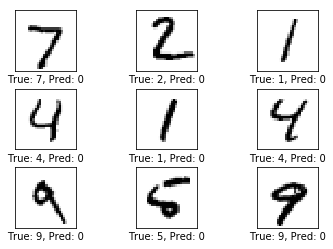

In [33]:
plot_example_errors()

## کارایی بعد از یک تکرار

پس از یک تکرار بهینه‌سازی، دقت مدل افزایش می‌یابد.

In [34]:
optimize(num_iterations=1)

In [35]:
print_accuracy()

Accuracy on test-set: 24.8%


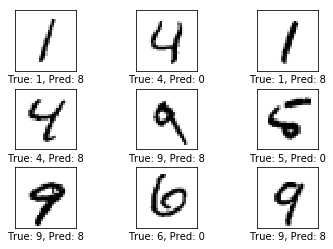

In [36]:
plot_example_errors()

همچنین می‌توان وزن‌ها را با تابع کمکی که قبلا نوشه‌ایم، نمایش دهیم. در این‌صورت وزن‌های مثبت با قرمز و وزن‌های منفی با رنگ آبی دیده می‌شوند. این وزن‌ها را می‌توان مانند فیلتری تصور کرد که بر تصاویر اعمال می‌شوند. 
به‌عنوان مثال وزن‌های که برای تشخیص عدد صفر به‌کار می‌روند، واکنش مثبتی به اشکال دایره‌ای دارند و واکنش منفی (آبی) به تصاویری دارای مرکز دایره‌ای خواهند داشت.
به‌طور مشابه وزن‌های استفاده شده برای تشخیص عدد 1، نسبت به خط عمودی واکنش مثبت دارند و نسبت به آنچه آن خط را احاطه می‌کند واکنش منفی دارد.

انتظار داریم تصویر وزن‌ها مشابه تصویر اعداد شوند تا پیش‌بینی و دسته‌بندی درست انجام شود.


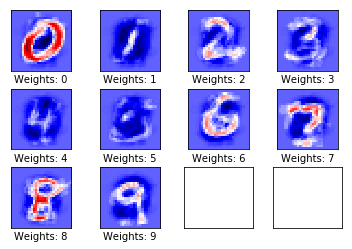

In [37]:
plot_weights()

## Performance after 10 optimization iterations

In [38]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [39]:
print_accuracy()

Accuracy on test-set: 80.7%


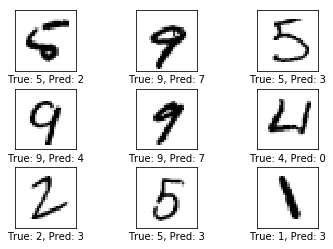

In [40]:
plot_example_errors()

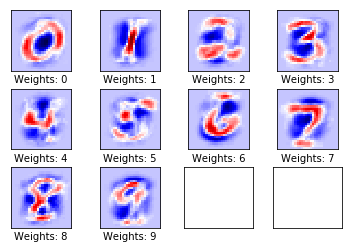

In [41]:
plot_weights()

## کارایی پس از 1000 تکرار


In [42]:
#10 تکرار قبلا انجام شده
optimize(num_iterations=990)

In [43]:
print_accuracy()

Accuracy on test-set: 91.5%


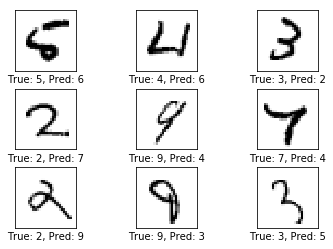

In [44]:
plot_example_errors()

حالا مدل در 1000 تکرار بهینه شده و آموزش یافته است که در هر تکرار از 100 تصویر برای بهینه‌سازی استفاده شده است. تصاویر وزن‌ها نشان می‌دهد که کمی پیچیده شده اند و به درستی عدد موردنظر را نشان نمی‌دهند. این امر نشان می‌دهد که بیش‌برازش اتفاق افتاده و مدل شروع به حفظ کردن الگوها کرده است و نه یافتن الگویی منظم برای تشخیص آن‌ها.


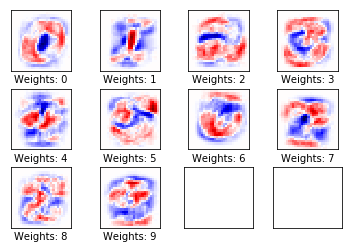

In [45]:
plot_weights()

حالا می‌توان ماتریس درهم ریختگی را نمایش داد.

[[ 959    0    2    2    0    4   11    1    1    0]
 [   0 1120    2    2    0    2    4    2    3    0]
 [   6   10  948   12    9    3   13   10   17    4]
 [   3    1   30  926    0   26    3    8    7    6]
 [   1    5   10    1  909    1   15    3    5   32]
 [  10    4    5   44    5  772   24    6   16    6]
 [   9    3    7    1    9    8  920    1    0    0]
 [   4   13   28    5    6    1    0  941    1   29]
 [  10   21   20   47    9   56   16   16  770    9]
 [  12    9    2   13   42   10    0   28    3  890]]


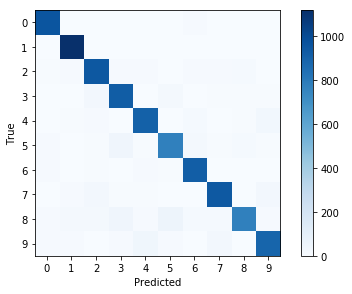

In [46]:
print_confusion_matrix()

در این مرحله کارمان با تنسورفلو تمام شده و میتوان session را بست تا منابع تخصیص یافته به آن ازاد گردند.

In [47]:
# session.close()

## تمرین

در پایین بخشی از پیشنهاداتی لیست شده‌اند که می‌توانید به عنوان تمرین بیشتر انجام دهید.

بهتر از قبل از اعمال تغییرات به این فایل، از ان یک نسخه پشتیبان تهیه کنید.

* مقدار نرخ یادگیری بهینه‌ساز را تغییر دهید.
* نوع بهینه‌ساز را به `AdagradOptimizer` یا `AdamOptimizer` تغییر دهید.
* اندازه هر دسته را از 100 به عدد دیگری مانند 1000 یا 1 تغییر دهید.
* تغییرات فوق چه تاثیری بر کارایی مدل دارند؟
* آیا فکر می‌کنید که اعمال تغییرات فوق تاثیر مشابهی بر مدلهای مختلف یادگیری دارند؟
* آیا هر بار که دستورات این فایل را (بدون تغییر پارامترها) اجرا می‌کنید نتایج متفاوتی می‌گیرید یا مشابه؟ چرا،
* تابع `plot_example_errors()` را به‌گونه‌ای تغییر دهید که `logits` و `y_pred` را نیز چاپ کند.
* از `sparse_softmax_cross_entropy_with_logits` به جای `softmax_cross_entropy_with_logits` استفاده کنید. شاید نیاز به تغییراتی در چندین جای کد باشد. درباره مزایا و معایب هر کدام از روش‌ها بحث کنید.
* سعی کنید کد بالا را بدون کمک گرفتن، خودتان بنویسید.
* کد بالا را برای یکی از دوستانتان توضیح دهید.